# sfHMM

Contents
--------

1. Basic Usage
2. Parameters and Methods
3. Attributes Added during Analysis
4. Customizing Plots
5. Additional Attributes and Methods in sfHMMn
6. Application to Motor Stepping
7. How to Use Step Finding Classes
8. How to Use GMM Clustering Classes
9. Working with Real Data

## 1. Basic Usage

Basically you can analyze your data by running following code:

```python
from sfHMM import io
io.read("path/to/file").run_all()
```

but to see what is happening inside the codes, first let's start with simulated data.

In [38]:
from sfHMM import hmm_sampling

data = hmm_sampling(3, 500) # 3-state, 500-frame

For single trajectory, use `sfHMM1`. Data can directly added to `sfHMM1` object by giving it as an argument.

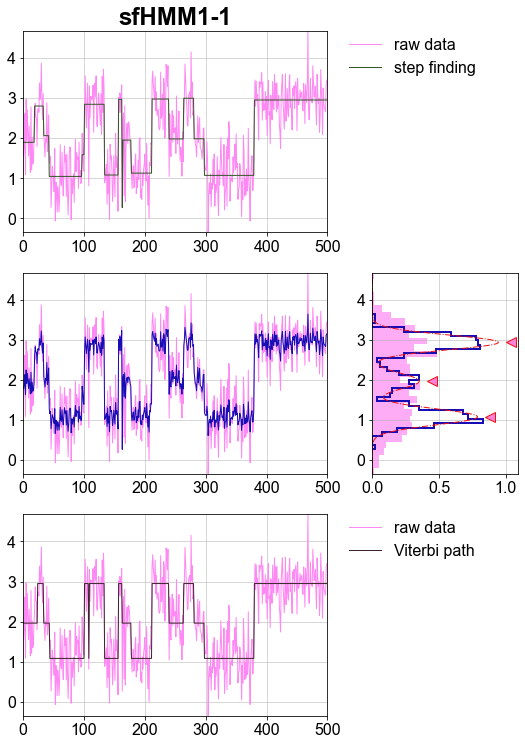

sfHMM1(krange=(1, 6), model='GaussStep', psf=0.042806973496989774,
       sg0=0.18207282022388305)

In [39]:
from sfHMM import sfHMM1

sf = sfHMM1(data)
sf.run_all()

For multiple trajectories, use `sfHMMn`. Here, data must be appended explicitly using `append` method.

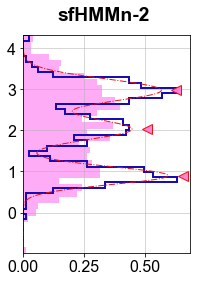

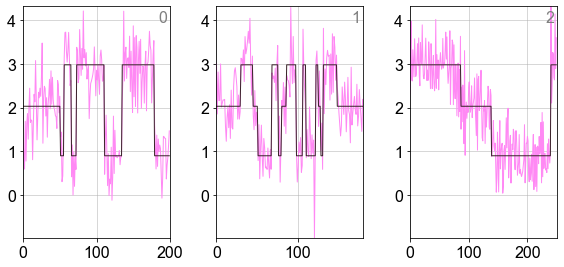

sfHMMn(krange=(1, 6), model='GaussStep', sg0=0.16464146770686516)

In [40]:
# simulate three trajectories
data1 = hmm_sampling(3, 200)
data2 = hmm_sampling(3, 180)
data3 = hmm_sampling(3, 250)

from sfHMM import sfHMMn

# make an object
msf = sfHMMn([data1, data2, data3])

# start analysis
msf.run_all()

## 2. Parameters and Methods

`sfHMM1` class and `sfHMMn` class have a similar structure (both inherit `sfHMMBase`) so that they have many attributes and methods in common. Also, `sfHMMBase` inherits `GaussianHMM` in [hmmlearn](https://github.com/hmmlearn/hmmlearn) so that all the methods in `GaussianHMM` are supported.

#### *Parameters*

All the parameters are optional.
- `sg0` ... The parameter used in denoising process. If signal change is $\Delta I$ then sg0 should be set to $\frac{\Delta I}{5}$ when you'd like to predifine it.
- `psf` ... The parameter used in step finding. Generally <0.1.
- `krange` ... Range of the number of hidden states. By default this is set to (1, 6), which is wide enough for most cases.
- `model` ... Step finding model. You can specify "g" for Gauss distribution (default) or "p" for Poisson distribution.
- `name` ... Name of the object.

#### *Methods*

sfHMM is composed of four steps.

1. `step_finding()` ... Step finding by likelihood maximization.
2. `denoising()` ... The standard deviation of noise is cut off to `sg0`.
3. `gmmfit()` ... Gaussian mixture model clustering.
4. `hmmfit()` ... HMM parameter initialization and optimization.

... and some utility functions.

- `plot()` ... visualize the results of sfHMM analysis.
- `run_all()` ... run all the four steps and plot the results.
- `tdp()` ... show the results in pseudo transition density plot.

Let's see what is going on by running sfHMM workflow one by one and plot the result every time.

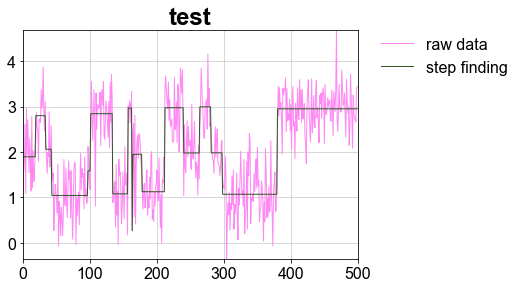

In [41]:
sf = sfHMM1(data, psf=0.03, name="test")

# 1. step finding
sf.step_finding()
sf.plot()

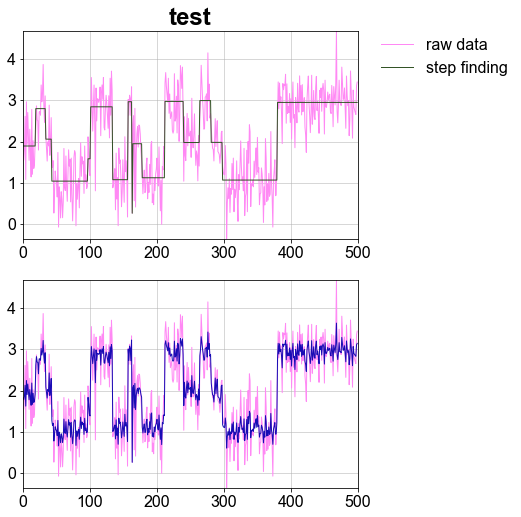

In [42]:
# 2. denoising
sf.denoising()
sf.plot()

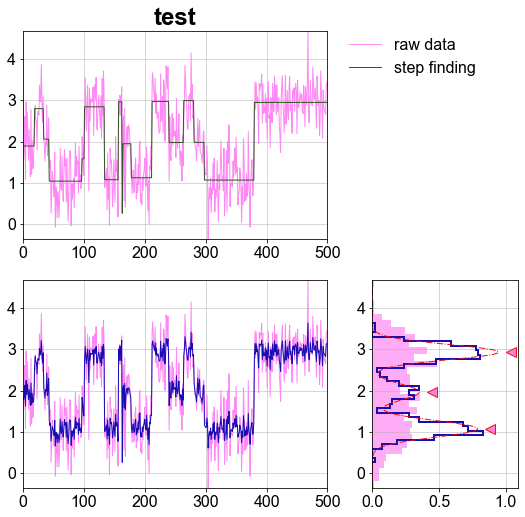

In [43]:
# 3. gmmfit
sf.gmmfit(n_init=3)
sf.plot()

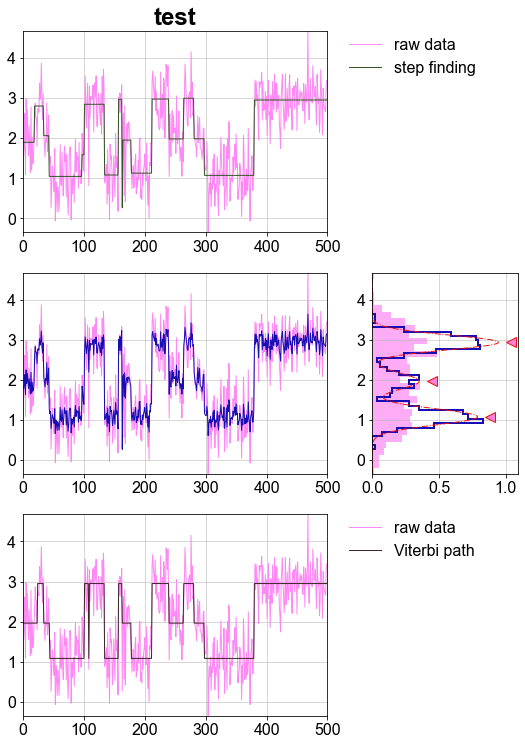

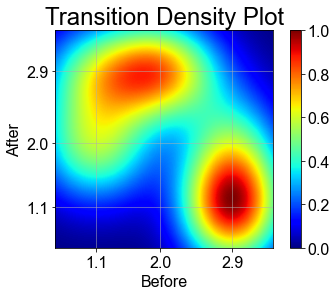

In [44]:
# 4. hmmfit
sf.hmmfit()
sf.plot()
sf.tdp()

In sfHMM object `sf`, each processed data are stored in:
- raw data &rarr; `self.data_raw`
- step finding results &rarr; `sf.step.fit`
- denoised trajectory &rarr; `sf.data_fil`
- Viterbi path of HMM &rarr; `sf.viterbi`

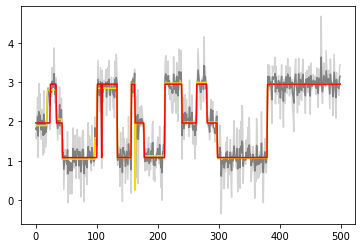

In [45]:
plt.plot(sf.data_raw, color="lightgray")
plt.plot(sf.data_fil, color="gray")
plt.plot(sf.step.fit, color="gold")
plt.plot(sf.viterbi, color="red")
plt.show()

## 3. Attributes Added during Analysis

Attributes will be sequencially added to the objects.

- After `step_finding`

  - `step` ... `GaussStep` if Gauss model or `PoissonStep` if Poisson model, but any `BaseStep` objects defined in `step` module are compatible. This object has following attributes:
  - `psf` ... Automatically determined here if needed.

- After `denoising`  

  - `data_fil` ... Data after denoised.
  - `sg0` ... Automatically determined here if needed.

- After `gmmfit`

  - `gmm_opt` ... The optimal Gaussian mixture model in the form of `GMM1` object. `GMM1` inherits `sklearn.mixture.GaussianMixture`. The only Difference is that all the parameters are sorted after fitting.

  - `gmm` ... `GMMs` object defined in `gmm` module, if AIC/BIC minimization is chosen. This object contains `GMM1` objects with different number of states.
  - `n_components` ... The number of states.
  - `states` ... State sequence, predicted only with the results in 1-3.

- After `hmmfit`
    
  - `means_`, `covars_`, `transmat_`, `startprob_` ... Parameters in Gaussian HMM. For detailed definition, see [hmmlearn](https://github.com/hmmlearn/hmmlearn).
  - `states` (updated after `gmmfit`) ... State sequence, optimized using Viterbi algorithm. This array takes values {0, 1, 2, ...}.
  - `viterbi` ... Signal sequence of Viterbi pass. This array takes values {`means_[0]`, `means_[1]`, `means_[2]`, ...}, so that basically you can plot `viterbi` and `data_raw` on the same figure.


Let's see some of them.

sf.sg0 =
0.18207282022388305
sf.n_components =
3
sf.means_ =
[[1.08254991]
 [1.9624228 ]
 [2.94916075]]
sf.states =
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

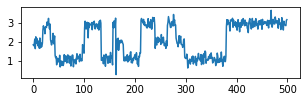

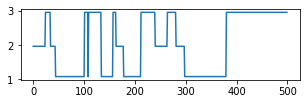

In [46]:
print("sf.sg0 =", sf.sg0, sep="\n")
print("sf.n_components =", sf.n_components, sep="\n")
print("sf.means_ =", sf.means_, sep="\n")
print("sf.states =", sf.states, sep="\n")
plt.figure(figsize=(5, 1.3))
plt.plot(sf.data_fil)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sf.viterbi)
plt.show()

## 4. Customizing Plots

The super class `sfHMMBase` has class attributes that is passed to `matplotlib` every time you plot. You can change them by updating the dictionaries.

- `colors` ... Line colors of each data.
- `styles` ... Styles of plot. See `rcParams` of `matplotlib`.


In [47]:
print(sfHMM1.colors)
print(sfHMM1.styles)

{'raw data': '#FF89F4', 'step finding': '#335426', 'denoised': '#180CB4', 'GMM': '#ED1111', 'GMM marker': '#FF81D8', 'Viterbi path': '#3B252B'}
{'font.size': 16, 'lines.linewidth': 1, 'axes.titlesize': 24, 'font.family': 'serif', 'font.serif': 'Arial', 'axes.grid': True, 'axes.labelsize': 16, 'grid.linewidth': 0.5, 'legend.frameon': False, 'boxplot.meanprops.linewidth': 1}


## 5. Additional Attributes and Methods in sfHMMn

Basically `sfHMMn` can be used similarly as `sfHMM1`, while it has other methods for convenience.

- `append` ... Append one dataset.
- `appendn` ... Append list of datasets.
- `delete` ... Delete dataset(s).
- `pop` ... Delete one dataset and return it.
- `from_pandas` ... Append datasets from `pandas.DataFrame`.
- `self[i]` ... The `sfHMM1` object of $i$-th trace. The real list of objects is `_sf_list`. Iteration is defined on this list.
- `run_all_separately` ... Run `run_all` for each `sfHMM1` separately.


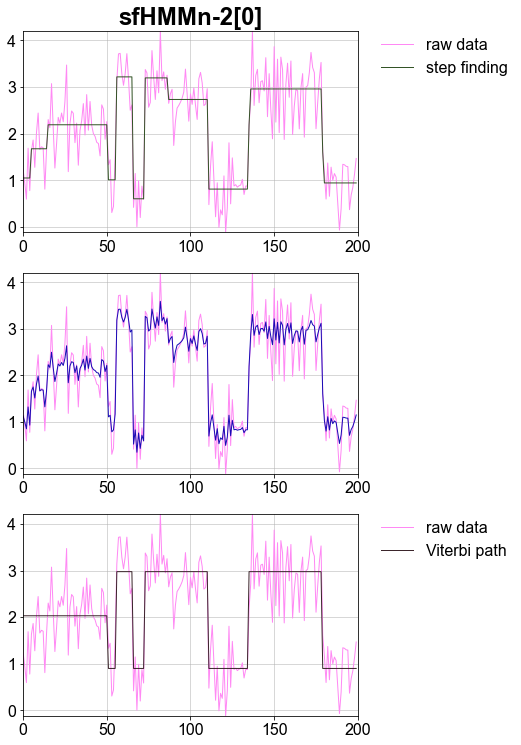

In [48]:
# plot the first trace and its analysis results.
msf[0].plot()

In [49]:
# print each name and how many steps it has
for sf in msf:
    print(sf.name, "...", sf.step.n_step, "steps")

sfHMMn-2[0] ... 13 steps
sfHMMn-2[1] ... 20 steps
sfHMMn-2[2] ... 9 steps


## 6. Application to Motor Stepping

sfHMM can be modified for application to motor stepping trajectories. `sfHMM1Motor` (for single trajectory) and `sfHMMnMotor` (for multiple trajectories) in `sfHMM.motor` module have similar API as `sfHMM1` and `sfHMMn` but there are slight differences due to specialization to motor stepping trajectories such as sparse transition and large number of states.

#### Differences in Parameters

- `krange` ... Because it is hard to define the number of states, this parameter is not needed to be predefined. This parameter can be estimated in `gmmfit()` based on the step finding results.
- `max_stride` ... The maximum size of state transition. Transition further than this will be ignored because transition probability for it will be near zero. For most motors this parameter should be set to 1 or 2.

#### Differences in Attributes and Methods

- `covariance_type` ... This is an attribute defined in `hmmlearn`. Because all the state should have the same distribution, this is set to `'tied'` here.
- `transmat_kernel` ... Independent paramter set in the transition probability matrix. The length of this array is equal to `max_stride*2+1`. This is passed to `transmat_` getter method every time to construct transition probability matrix.
- `gmmfit()` ... `method="Dirichlet"` is default because it is precise enough and it is much faster for big data. Also, if you want to use the predifined `krange`, you need to explicitly add keyward argument `estimation="none"`.
- `tdp()` ... In the case of motor stepping, transition desity plot is not a straightforward way to visualize transition. Histogram of transition frequency is plotted here.

#### Difference in HMM Algorithms

Although you don't need to care much about them, forward/backward algorithm and Viterbi algorithm is modified from the original ones because there are some restrictions in transition probability matrix. In `hmmlearn` those algorithms are coded in cython file "_hmmc.pyx", while in `sfHMM.motor` modified algorithms in "_hmmc_motor.pyx" are used instead.


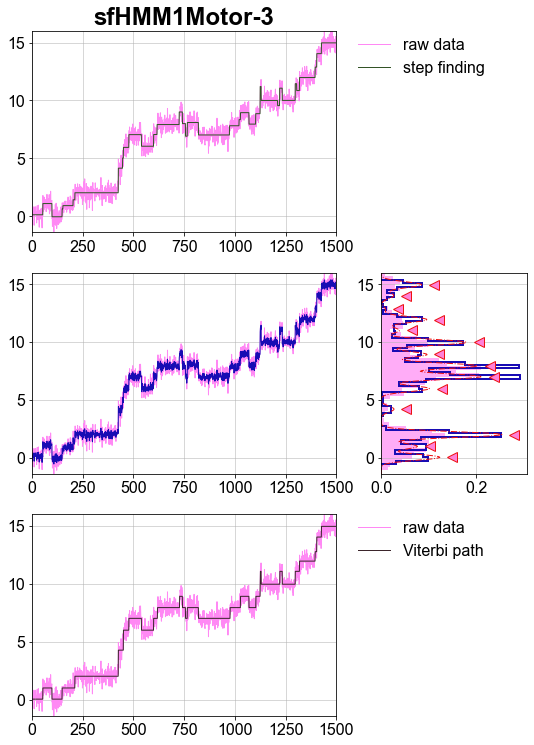

sfHMM1Motor(krange=(14, 19), model='GaussStep', psf=0.02517000230958917,
            sg0=0.19902517344287507)

In [50]:
from sfHMM import motor_sampling
from sfHMM.motor import sfHMM1Motor
data = motor_sampling(n_data=1500, rand=0)
sf = sfHMM1Motor(data, max_stride=2)
sf.run_all()

Or if you find it's hard to see, give range argument to `plot()` method.

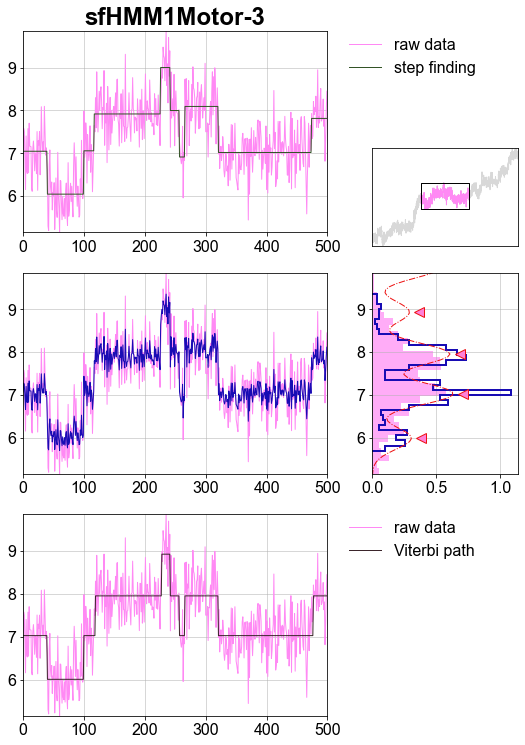

In [51]:
sf.plot([500, 1000])

The information of transition is different in motor step analysis.

transmat_kernel =
[4.47138591e-24 5.78018624e-03 9.80029627e-01 1.39308987e-02
 2.59288126e-04]
transmat_ =
[[0.99 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.98 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.98 0.01 0.  ]
 [0.   0.   0.  

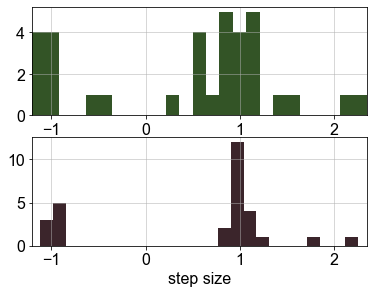

In [52]:
print("transmat_kernel =", sf.transmat_kernel, sep="\n")
print("transmat_ =", np.round(sf.transmat_, 2), sep="\n")
sf.tdp()

## 7. How to Use Step Finding Classes

In `sfHMM.step` module, several step finding algorithms are provided. All the classes inherit `BaseStep` so that they have same API.

*Parameters*

- `fit` ... Fitting result.
- `n_step` ... The number of steps (the word "step" here means a plateau, or the region between two signal change points).
- `step_list` ... List of signal change points.
- `mu_list` ... list of mean values of each step, or step height.
- `len_list` ... list of step lengths, or dwell time (`step_list[i+1] - step_list[i]`).
- `step_size_list` ... list of signal change (`mu_list[i+1] - mu_list[i]`). 

*Methods*

- `multi_step_finding()` ... Find new steps until likelihood reaches the maximum.
- `plot()` ... Plot the raw data and the fitting.

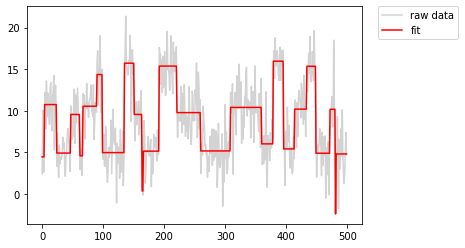

In [53]:
from sfHMM.step import GaussStep
# simulate a Gaussian trajectory
data_gauss = hmm_sampling(3, 500, scale=5, rand=1234)

step_g = GaussStep(data_gauss)
step_g.multi_step_finding() # find steps
step_g.plot() # plot results

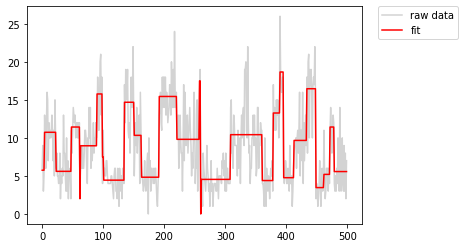

In [54]:
from sfHMM.step import GaussStep, PoissonStep
# simulate a Poissonian trajectory
data_poisson = hmm_sampling(3 ,500, scale=5, rand=1234, poi=True)

step_p = PoissonStep(data_poisson)
step_p.multi_step_finding() # find steps
step_p.plot() # plot results

In my implementation, calculation results in one loop are efficiently passed to next loop. You can fit 100,000-frame trajectory within **1 sec**!

In [55]:
data = hmm_sampling(3 ,10**5, scale=5)
%time step_g = GaussStep(data).multi_step_finding()

Wall time: 259 ms


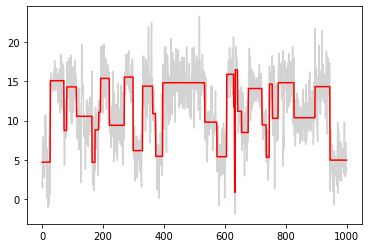

n_step = 3290


In [56]:
# because the data size is too large, let's see the first 1,000 frame.
plt.plot(step_g.data[:1000], color="lightgray")
plt.plot(step_g.fit[:1000], color="red")
plt.show()
print("n_step =", step_g.n_step)

## 8. How to Use GMM Clustering Classes

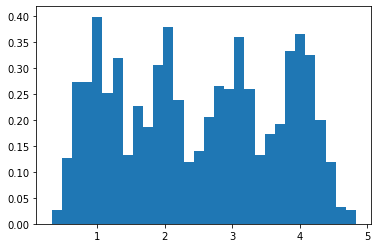

In [57]:
data = hmm_sampling(4, n_data=1000, trs=0.5, sigma=0.3) # so fast transition that almost no correlation visible
plt.hist(data, bins=30, density=True)
plt.show()

With `GMMs` class you can easily fit the data to correct model

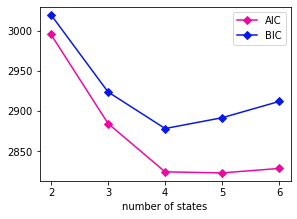

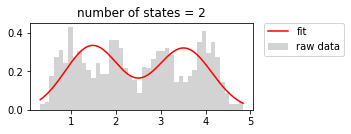

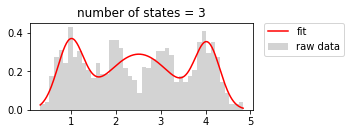

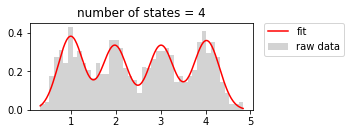

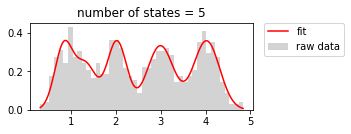

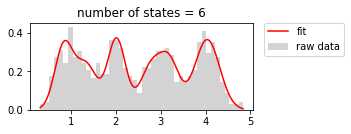

In [58]:
from sfHMM.gmm import GMMs
gmms = GMMs(data, krange=(2, 6))
gmms.fit()
gmms.show_aic_bic()
gmms.plot_all()

In [59]:
# get the best model that minimizes BIC
gmm_optimal = gmms.get_optimal(criterion="bic")
print(gmm_optimal)
print(gmm_optimal.means_)

GMM1(n_components=4)
[[0.99810535]
 [1.97977217]
 [3.00872095]
 [4.02155806]]


## 9. Working with Real Data

Here in this section I'll introduce how to deal with real experimental data saved as such as csv, xlsx or dat files. 


In [60]:
# Load sample data with pandas
import pandas as pd

path = r"sample_data\sample.dat"

df = pd.read_csv(path, sep="\s+", encoding="utf-8")
df

,Data1,Data2,Data3
0,1.883481,3.875118,4.046193
1,1.312959,3.367213,4.771775
2,2.589254,3.866412,3.418180
3,1.641473,3.755194,4.572647
4,2.422465,4.147751,3.782857
...,...,...,...
518,1.280622,NaN,NaN
519,1.256137,NaN,NaN
520,0.051981,NaN,NaN
521,2.035814,NaN,NaN


Next, append the loaded data to sfHMMn object using `from_pandas()` method. `from_pandas()` method calls `append` inside so that DataFrame is automatically reshaped into appropriate format. 

Let's see what the trajectories look like using `plot()`. 

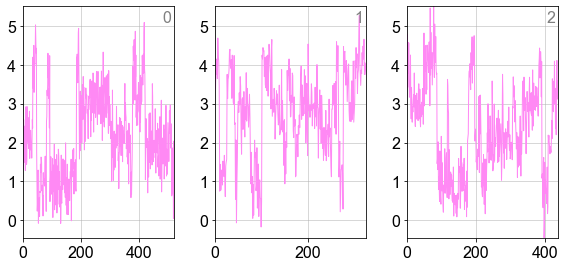

In [61]:
msf = sfHMMn(df, psf=0.03, name="I/O practice")
msf.plot()

Now it's ready to start sfHMM analysis.

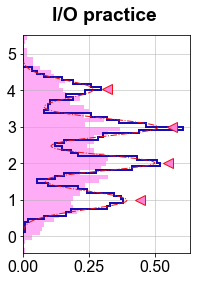

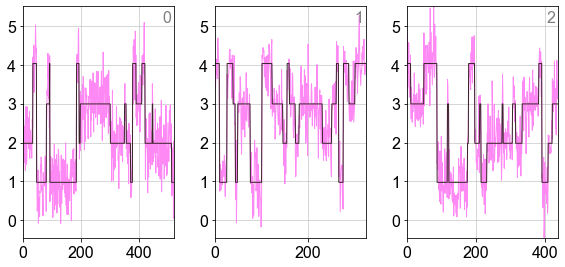

sfHMMn(krange=(1, 6), model='GaussStep', psf=0.03, sg0=0.19965640838999993)

In [62]:
msf.run_all()

In `sfHMM.io`, all what you do above can be done in a straightforward way. The `read()` function can load a file and directly returns an `sfHMMn` object. 

Make sure the contents are reshaped in following formats:

|Data1|Data2| ... |
|:---:|:---:|:---:|
|  3.5|  9.1| ... |
|  2.2|  5.0| ... |
|  :  |  :  |  :  |

or

|names|values|
|:---:|:----:|
|Data1|   3.5|
|Data1|   2.2|
|  :  |   :  |
|Data1|   6.3|
|Data2|   9.1|
|Data2|   5.0|
|  :  |   :  |
|Data2|   6.4|
|  :  |   :  |


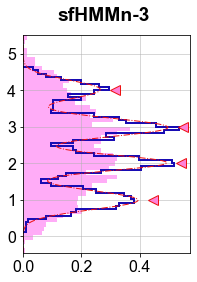

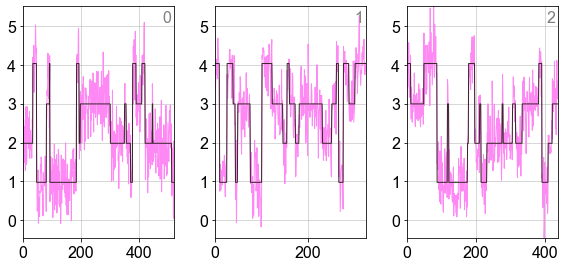

sfHMMn(krange=(1, 6), model='GaussStep', sg0=0.20031056947069442)

In [63]:
from sfHMM import io 
msf = io.read(path)
msf.run_all()

In [64]:
path = r"sample_data\sample.xlsx"
d = io.read_excel(path)
print(d)

{'Exp1': sfHMMn(model='GaussStep'), 'Exp2': sfHMMn(model='GaussStep')}


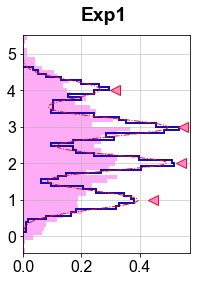

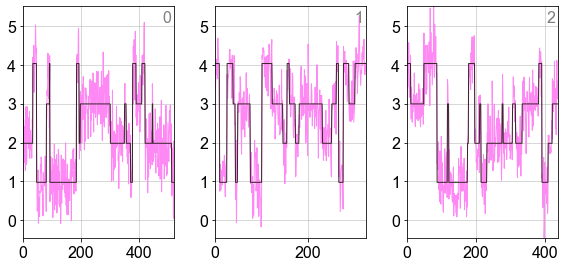

sfHMMn(krange=(1, 6), model='GaussStep', sg0=0.20031056947725157)

In [65]:
d["Exp1"].run_all()